### Step 1: Read and Preprocess Data  

#### 1. Initial Attempt with Hugging Face Library
Initially, I planned to use the Hugging Face library to download and preprocess the dataset directly. However, this approach proved to be:
- **Drastically slow**, making experimentation inefficient.
- **Inconvenient** due to library-specific constraints on data manipulation.

To address these issues, I decided to download a smaller, **-mini** version of the dataset locally and process it with familiar tools (e.g., Pandas).

---

#### 2. Machine Limitations and Sampling Strategy
Upon attempting to load the dataset, I realized that:
- My machine lacked sufficient memory and computational power to handle the dataset in its entirety.
- Even a significant portion of the data was too large to process efficiently.

### Solution:
I opted to **sample the dataset**, selecting only a subset of records for each `client_id`. This sampling strategy ensures:
- The sample remains **representative** of the full dataset.
- The sample size is **manageable**, enabling faster experimentation and analysis.


In [2]:
# Define paths to data:
DIALOG_PATH = "./detail/dialog"
GEO_PATH = "./detail/geo"
TRX_PATH = "./detail/trx"
TARGET_PATH = "./targets"

In [3]:
import pandas as pd
import os

# Let's explore fold 0
FOLD = 0

# Select only 10 records for each `client_id`.
dialog = pd.read_parquet(os.path.join(DIALOG_PATH, f'fold={FOLD}')).groupby('client_id').head(10)
geo = pd.read_parquet(os.path.join(GEO_PATH, f'fold={FOLD}')).groupby('client_id').head(10)
trx = pd.read_parquet(os.path.join(TRX_PATH, f'fold={FOLD}')).groupby(['client_id', 'event_type']).head(10)

In [4]:
# Notice that the number of clients is not the same in these dataframes
print(f"Number of unique clients in trx: {trx['client_id'].nunique()}")
print(f"Number of unique clients in dialog: {dialog['client_id'].nunique()}")
print(f"Number of unique clients in geo: {geo['client_id'].nunique()}")

# Filter to ensure consistency
trx = trx[trx['client_id'].isin(dialog['client_id'])]
geo = geo[geo['client_id'].isin(dialog['client_id'])]

Number of unique clients in trx: 20032
Number of unique clients in dialog: 9401
Number of unique clients in geo: 14863


In [5]:
dialog.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36673 entries, 0 to 43555
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   36673 non-null  object        
 1   event_time  36673 non-null  datetime64[ns]
 2   embedding   36673 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.1+ MB


In [6]:
geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70736 entries, 0 to 13812215
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   70736 non-null  object        
 1   event_time  70736 non-null  datetime64[ns]
 2   geohash_4   70736 non-null  int32         
 3   geohash_5   70736 non-null  int32         
 4   geohash_6   70736 non-null  int32         
dtypes: datetime64[ns](1), int32(3), object(1)
memory usage: 2.4+ MB


In [7]:
trx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608307 entries, 102 to 7633900
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   client_id      608307 non-null  object        
 1   event_time     608307 non-null  datetime64[ns]
 2   amount         608307 non-null  float32       
 3   event_type     608307 non-null  int32         
 4   event_subtype  608307 non-null  int32         
 5   currency       608304 non-null  float64       
 6   src_type11     600858 non-null  float64       
 7   src_type12     600858 non-null  float64       
 8   dst_type11     600979 non-null  float64       
 9   dst_type12     600979 non-null  float64       
 10  src_type21     607761 non-null  float64       
 11  src_type22     607761 non-null  float64       
 12  src_type31     607127 non-null  float64       
 13  src_type32     607127 non-null  float64       
dtypes: datetime64[ns](1), float32(1), float64(9), int32(2)

### Step 2: Visualize Data

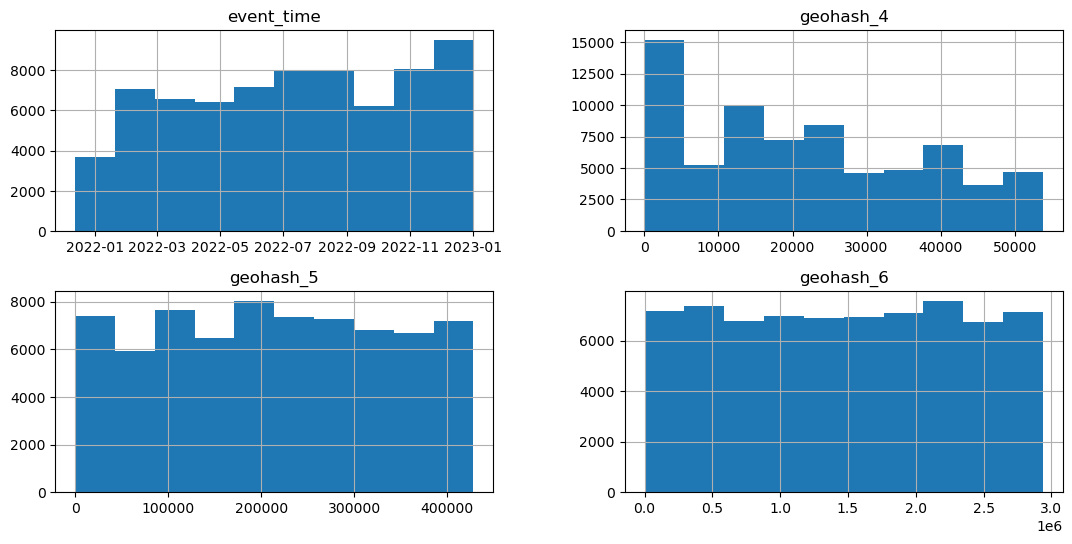

In [57]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (13, 6)
geo.hist();

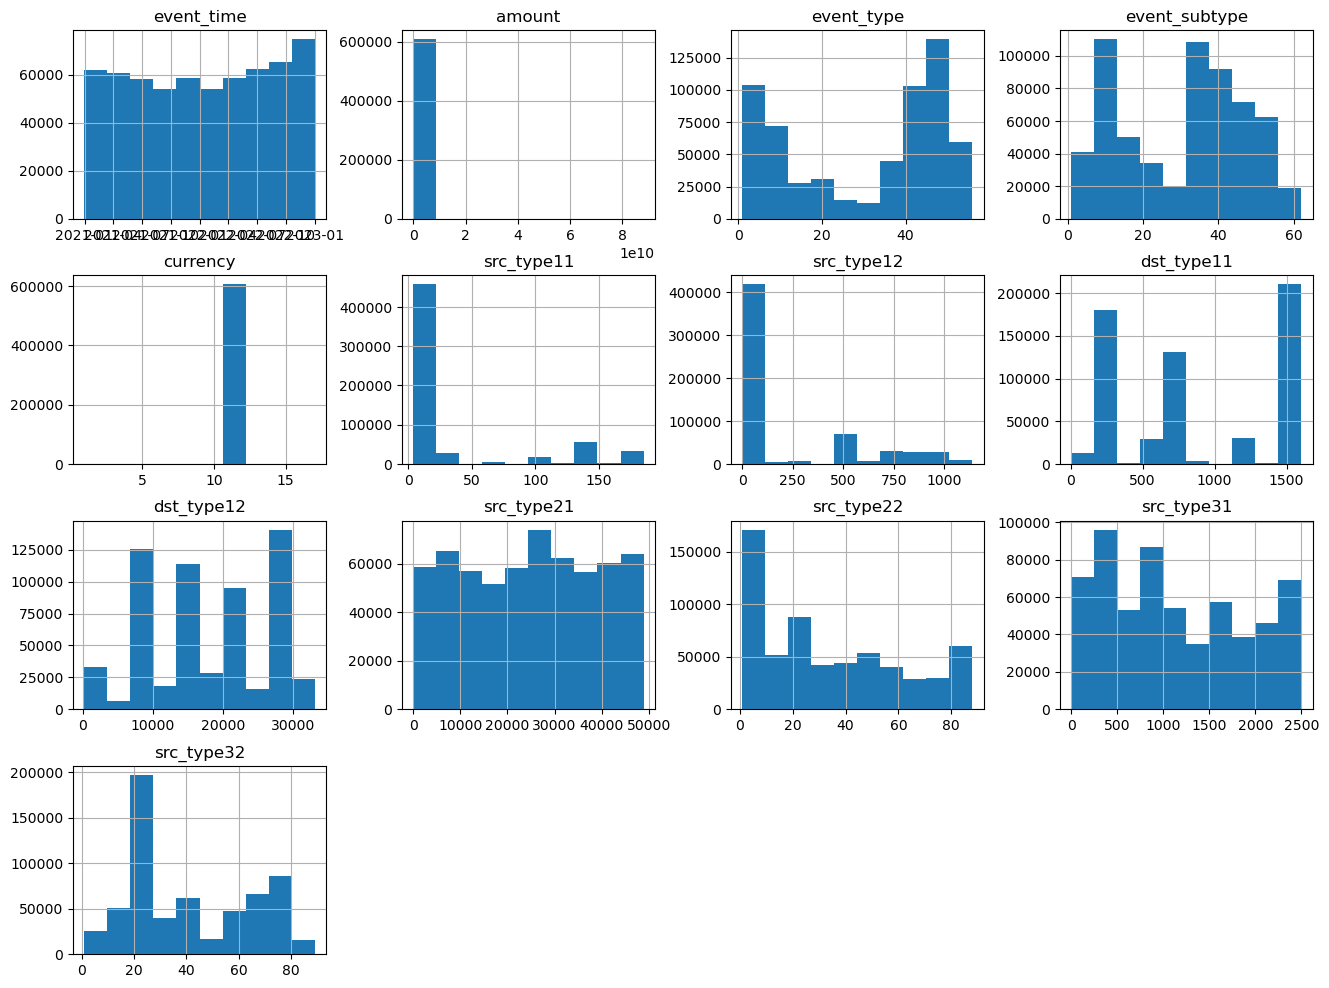

In [9]:
plt.rcParams['figure.figsize'] = (16, 12)
trx.hist();

**Brief conclusion**: most of the features are neither uniformly nor normally distributed.

### Step 3: Feature Engineering

In [10]:
import numpy as np

# Group transactions by month
trx['month'] = trx['event_time'].dt.to_period('M')
geo['month'] = geo['event_time'].dt.to_period('M')
dialog['month'] = dialog['event_time'].dt.to_period('M')

def mode(x):
    return x.mode().iloc[0] if not x.mode().empty else None

dialog_features = dialog.groupby(['client_id', 'month'])['embedding'].apply(np.mean).apply(np.mean).reset_index()

# Count unique geohashes and calculate movement diversity.
geo_features = geo.groupby(['client_id', 'month']).agg({
    'geohash_4': 'nunique',
    'geohash_5': 'nunique',
    'geohash_6': 'nunique'
}).reset_index()

trx_features = trx.groupby(['client_id', 'month']).agg({
    'event_type': ['nunique', mode],
    'currency': 'nunique',
    'amount': ['sum', 'mean', 'max'],
}).reset_index()
trx_features.columns = ['_'.join(col).strip() for col in trx_features.columns.values]  # Flatten MultiIndex
trx_features.rename(columns={'client_id_':'client_id', 'month_':'month'}, inplace=True)

trx_features.head()

,client_id,month,event_type_nunique,event_type_mode,currency_nunique,amount_sum,amount_mean,amount_max
0,000e047a31e50ba35f71c81962b4eb0b9a2d6080cf23a1...,2021-01,1,49,1,114661.867188,114661.867188,114661.867188
1,000e047a31e50ba35f71c81962b4eb0b9a2d6080cf23a1...,2021-03,1,56,1,50160.746094,50160.746094,50160.746094
2,000e047a31e50ba35f71c81962b4eb0b9a2d6080cf23a1...,2021-04,1,1,1,49103.750000,49103.750000,49103.750000
3,000e047a31e50ba35f71c81962b4eb0b9a2d6080cf23a1...,2021-05,1,56,1,35232.402344,35232.402344,35232.402344
4,000e047a31e50ba35f71c81962b4eb0b9a2d6080cf23a1...,2021-06,1,1,1,30871.998047,30871.998047,30871.998047


### **Define Objective**: Predict whether a client will perform one of four target actions (e.g. will take a loan).  

Equivalent to a multi-label classification problem:  
- **Input Features:**
  - Historical transactions
  - Dialog embeddings
  - Geographic activity
- **Output Labels:**  
  For each client *i* at time *t*, predict y(*i*,*t*), indicating the presence (1) or absence (0) of product *k*.

<u>Mathematical formulation</u>:
y(*i*,*t*) = f(X(*i*,*t-1*), ..., X(*i*,*t-N*)),
where *f* is the predictive function, X(*i*,*t*) represents the client features (transactions, embeddings, geo-activity) at time *t*, and *N* is the historical window size.

In [24]:
targets = pd.read_parquet(os.path.join(TARGET_PATH, f'fold={FOLD}'))
# Targets are too sparse -> Filter
targets = targets[targets[['target_1', 'target_2', 'target_3', 'target_4']].eq(1).any(axis=1)]
targets.rename(columns={'mon':'month'}, inplace=True)
targets['month'] = pd.to_datetime(targets['month']).dt.to_period('M')
targets.head()

,client_id,month,target_1,target_2,target_3,target_4,trans_count,diff_trans_date
40,0af35089e0209afc40991bebc9938f045cf2b549a0c49d...,2022-06,1,0,0,1,0,NaN
201,18e7bb6c310d0ee7aa5ac0bc30332f9d024445b0938a78...,2022-11,0,0,0,1,0,NaN
203,18e7bb6c310d0ee7aa5ac0bc30332f9d024445b0938a78...,2023-01,0,0,1,0,12,5.0
257,1ec4457a99c85b7e7ee176913c5b8af15545728e76fedf...,2022-07,1,0,0,0,0,NaN
354,247f277dea55b00664fa74864921864c8c14fd33f15c97...,2022-08,1,0,0,0,80,13.0


In [25]:
targets.describe()

,target_1,target_2,target_3,target_4,trans_count,diff_trans_date
count,2609.000000,2609.000000,2609.000000,2609.000000,2609.000000,2283.000000
mean,0.410885,0.050594,0.357992,0.243005,138.290916,5.632501
std,0.492089,0.219209,0.479502,0.428980,180.070202,19.333920
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,66.000000,1.000000
75%,1.000000,0.000000,1.000000,0.000000,195.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,983.000000,305.000000


### Step 4: Compose the final dataframe

In [26]:
# Merge features
merged_data = dialog_features.merge(geo_features, on=['client_id', 'month'], how='left')
merged_data = merged_data.merge(trx_features, on=['client_id', 'month'], how='left')

# Add target labels
final_data = merged_data.merge(targets, on=['client_id', 'month'], how='inner')

In [27]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   client_id           829 non-null    object   
 1   month               829 non-null    period[M]
 2   embedding           829 non-null    float32  
 3   geohash_4           252 non-null    float64  
 4   geohash_5           252 non-null    float64  
 5   geohash_6           252 non-null    float64  
 6   event_type_nunique  688 non-null    float64  
 7   event_type_mode     688 non-null    float64  
 8   currency_nunique    688 non-null    float64  
 9   amount_sum          688 non-null    float32  
 10  amount_mean         688 non-null    float32  
 11  amount_max          688 non-null    float32  
 12  target_1            829 non-null    int32    
 13  target_2            829 non-null    int32    
 14  target_3            829 non-null    int32    
 15  target_4            829

In [28]:
def fill_missing_values(df):
    # Categorical columns
    categorical_cols = ['event_type_mode', 'currency_nunique']
    df[categorical_cols] = df[categorical_cols].fillna(-1)  # Use -1 for missing categorical data

    # Numerical columns
    numerical_cols = ['amount_sum', 'amount_mean', 'amount_max', 
                      'event_type_nunique', 'diff_trans_date']
    df[numerical_cols] = df[numerical_cols].fillna(0)  # Replace NaNs with 0 for sums/counts

    # Geographic columns
    geo_cols = ['geohash_4', 'geohash_5', 'geohash_6']
    df[geo_cols] = df[geo_cols].fillna(0)  # Assume no geohashes for missing data
    
    return df

# Apply the fill function to trx_features
final_data = fill_missing_values(final_data)

# Verify the result
print(final_data.isnull().sum())  # Ensure no missing values remain

client_id             0
month                 0
embedding             0
geohash_4             0
geohash_5             0
geohash_6             0
event_type_nunique    0
event_type_mode       0
currency_nunique      0
amount_sum            0
amount_mean           0
amount_max            0
target_1              0
target_2              0
target_3              0
target_4              0
trans_count           0
diff_trans_date       0
dtype: int64


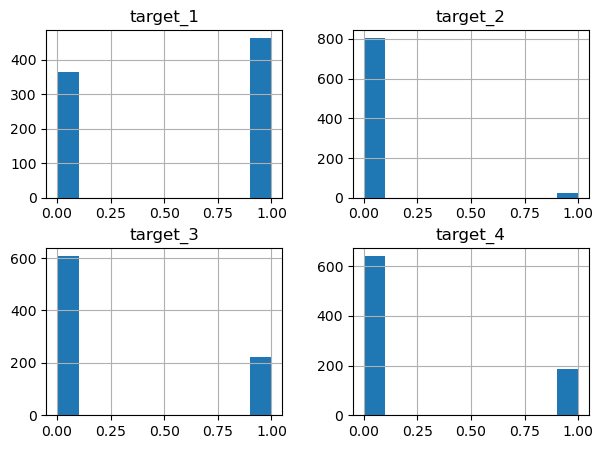

In [ ]:
# Target 2 is crucially unbalanced
plt.rcParams['figure.figsize'] = (7, 5)
final_data[['target_1', 'target_2', 'target_3', 'target_4']].hist();

In [66]:
# Select features and targets
features = ['event_type_mode', 'currency_nunique', 
            'amount_sum', 'amount_mean', 'amount_max', 
            'event_type_nunique', 'diff_trans_date',
            'geohash_4', 'geohash_5', 'geohash_6', 'embedding']
targets = ['target_1', 'target_2', 'target_3', 'target_4']

# Split into X and Y
X = final_data[features]
Y = final_data[targets]

In [67]:
# Weak correlation with targets. In general, more advanced preprocessing is needed.
corr_matrix = final_data[features + targets].corr()
corr_with_targets = corr_matrix[['target_1', 'target_2', 'target_3', 'target_4']]
print(corr_with_targets)

                    target_1  target_2  target_3  target_4
event_type_mode    -0.101469 -0.033372  0.109928  0.007041
currency_nunique   -0.183591  0.042793  0.154176  0.048706
amount_sum         -0.036124  0.174966  0.055003 -0.046259
amount_mean        -0.036404  0.126152  0.056152 -0.045035
amount_max         -0.024519  0.117802  0.075340 -0.046785
event_type_nunique -0.156823  0.159435  0.144282 -0.042724
diff_trans_date     0.075582 -0.027770 -0.073019 -0.021124
geohash_4          -0.018185  0.066057  0.007172 -0.041727
geohash_5          -0.021499  0.049762  0.002538 -0.032006
geohash_6          -0.019176  0.052744  0.005432 -0.036969
embedding           0.002970 -0.012050 -0.022270  0.027970
target_1            1.000000 -0.132699 -0.524274 -0.446683
target_2           -0.132699  1.000000 -0.077182 -0.064395
target_3           -0.524274 -0.077182  1.000000 -0.287420
target_4           -0.446683 -0.064395 -0.287420  1.000000


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize multi-output classifier
multi_rf = MultiOutputClassifier(RandomForestClassifier(random_state=42, n_jobs=-1))

# Fit the model
multi_rf.fit(X_train, Y_train)

# Predict on test data
Y_pred = multi_rf.predict(X_test)

# Evaluate performance
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred, target_names=targets))

In [62]:
# Extract feature importance from each estimator
feature_importances = np.mean(
    [est.feature_importances_ for est in multi_rf.estimators_], axis=0)

# Map to feature names
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(importance_df)

               Feature  Importance
10           embedding    0.198562
3          amount_mean    0.164490
2           amount_sum    0.151527
4           amount_max    0.145728
0      event_type_mode    0.094387
6      diff_trans_date    0.090555
5   event_type_nunique    0.086129
9            geohash_6    0.022652
8            geohash_5    0.021406
7            geohash_4    0.020584
1     currency_nunique    0.003979
